In [578]:
import cv2

In [579]:
import numpy as np

import re

In [580]:
import pytesseract as tess

In [581]:
tess.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [582]:
from PIL import Image

In [583]:
from matplotlib import pyplot as plt

In [584]:
from googletrans import Translator

In [621]:
translator = Translator(service_urls=[
      'translate.google.com',
      'translate.google.co.kr',
])

In [622]:
def get_params():
    params = ""
    params += "--psm 12"

    configParams = []
    def configParam(param, val):
      return "-c " + param + "=" + val

    configParams.append(("chop_enable", "T"))
    configParams.append(('use_new_state_cost','F'))
    configParams.append(('segment_segcost_rating','F'))
    configParams.append(('enable_new_segsearch','0'))
    configParams.append(('textord_force_make_prop_words','F'))
    configParams.append(('tessedit_char_blacklist', '}><L'))
    configParams.append(('textord_debug_tabfind','0'))
    params += " ".join([configParam(p[0], p[1]) for p in configParams])
    return params

In [623]:
img = cv2.imread('sample.jpg')

if (img.shape[0] > 300):
    scale_percent = 30 # percent of original size
else:
    scale_percent = 200 # percent of original size

width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [624]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.imshow("image", img_gray)
# cv2.waitKey(0)

In [625]:
img_gray = cv2.bitwise_not(cv2.adaptiveThreshold(img_gray, 255, cv2.THRESH_BINARY, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 75, 10))
# cv2.imshow("image", img_gray)
# cv2.waitKey(0)

In [626]:
kernel = np.ones((2,2),np.uint8)

In [627]:
img_gray = cv2.erode(img_gray,kernel,iterations = 3)
# cv2.imshow("image", img_gray)
# cv2.waitKey(0)

In [628]:
img_gray = cv2.bitwise_not(img_gray)
# cv2.imshow("image", img_gray)
# cv2.waitKey(0)

In [629]:
im2, contours, hierarchy = cv2.findContours(img_gray,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [630]:
pruned_contours = []

In [631]:
mask = np.zeros_like(img)

In [632]:
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

In [633]:
height, width, channel = img.shape

In [634]:
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > 100 and area < ((height / 3) * (width / 3)):
      pruned_contours.append(cnt)

In [635]:
# find contours for the mask for a second pass after pruning the large and small contours
cv2.drawContours(mask, pruned_contours, -1, (255,255,255), 1)
im2, contours2, hierarchy = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
# cv2.imshow("image", img_gray)
# cv2.waitKey(0)

In [636]:
final_mask = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_BGR2GRAY)

In [637]:
koreanTexts = []
for cnt in contours2:
    area = cv2.contourArea(cnt)
    if area > 1000 and area < ((height / 3) * (width / 3)):
      draw_mask = cv2.cvtColor(np.zeros_like(img), cv2.COLOR_BGR2GRAY)
      approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
      cv2.fillPoly(draw_mask, [approx], (255,0,0))
      cv2.fillPoly(final_mask, [approx], (255,0,0))
      image = cv2.bitwise_and(draw_mask, cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
      draw_mask_inverted = cv2.bitwise_not(draw_mask)
      image = cv2.bitwise_or(image, draw_mask_inverted)
      y = approx[:, 0, 1].min()
      h = approx[:, 0, 1].max() - y
      x = approx[:, 0, 0].min()
      w = approx[:, 0, 0].max() - x
      image = image[y:y+h, x:x+w]
      pil_image = Image.fromarray(image)

      text = tess.image_to_string(pil_image, lang="kor", config=get_params())
      
      text = re.sub(r"\n", "", text)

      if text:
#         print ("Attempt: " + text)
        koreanTexts.append(text)

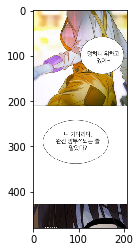



명하니 뭐하고 ,있어~”~  ->  Do you people doing, I ~ "~
나 기다리다.완전 망부석되는 줄알았다?”  ->  I waited. Mangbuseok fully knew that? "


In [638]:
# print(koreanTexts)
plt.imshow(img)
plt.show()
print('\n')
translationTexts = translator.translate(list(reversed(koreanTexts)), dest='en', src='ko')
for translation in translationTexts:
    print(translation.origin, ' -> ', translation.text)